### Import

In [2]:
import numpy as np
from sklearn.decomposition import FastICA
from sklearn.metrics.pairwise import euclidean_distances
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import math 
import warnings
warnings.filterwarnings('ignore')

### Parameter für RFB-Kernel

In [3]:
def find_median_distance(Z):
    size1 = np.shape(Z)[0] 
    if(size1 > 100):
        Zmed = Z[np.random.choice(size1,100,replace = False)]
        size1 = 100
        
    else:
        Zmed = Z
    
    Zmed_later = Zmed
    Zmed = np.matrix(Zmed).T
    Zmedsq = np.multiply(Zmed,Zmed)
    
    G = Zmedsq
    Q = np.tile(G,(1,size1))
    R = np.tile(G,(1,size1)).T
    dists = Q + R - 2 * (Zmed @ Zmed.T)
    dists = dists - np.tril(dists)
    dists = np.asarray(dists)
    median_dist = np.median(dists[np.absolute(dists)>0]) 
    return np.absolute(median_dist)

### KSD-Methode 


In [4]:
def KSD(x,W,Sqx):
    x = x.reshape(-1,1)
    h = np.sqrt(0.5 * find_median_distance(x)) 
    Sqx = np.matrix(Sqx(x,W)).T  
    x = x.reshape(1,-1)
    x = np.matrix(x).T
    XY = x @ x.T
    
    x2 = np.multiply(x,x)
    sumx = np.multiply(x,Sqx)

    X2e = np.tile(x2, (1,np.shape(x)[0]))
    H = (X2e + X2e.T - 2*XY)
    Kxy = np.exp(-H/(2*h**2))
    
    sqxdy = -(Sqx @ x.T - np.tile(sumx,(1,np.shape(x)[0])))/h**2
    dxsqy = sqxdy.T
    dxdy = (-H/h**4 + 1/h**2)
    M = np.multiply((Sqx @ Sqx.T + sqxdy + dxsqy + dxdy) , Kxy)
    u = M - np.diag(np.diag(M))
    ksd = np.sum(u)/(np.shape(x)[0]*(np.shape(x)[0]-1))
    return u,ksd 

def boot(nboot,n,u,ksd):
    bootstrapSamples = np.zeros(nboot)
    for i in range(nboot):
        wtsboot = (stats.multinomial.rvs(n,size=1,p=1/n * np.ones(n))/n).T
        bootstrapSamples[i] = (wtsboot.T-1/n)@u@(wtsboot-1/n)
    p = np.mean(bootstrapSamples >= ksd)
    return p   


Wie sampeln wir aus p?\
Paper: Wenn $s_j \sim exp(G(t)) \rightarrow$ $x = W^{-1}s \sim log(p(x))$ \
Also müssen wir aus $exp(G(t))$ sampeln. CDF hat keine geschlossene Form, somit kann kein Invers Sampling angewandt werden. Lösung: 

## Rejection Sampling

In [6]:
def sample_x(num_samples,W_inv, xmin=-6, xmax=6, ymax=0.29, batch=1000):
    G = lambda x: np.exp(-2*np.log(np.cosh(np.pi/(2*np.sqrt(3)) * x )) - np.log(4))
    samples = []
    while len(samples) < num_samples:
        x = np.random.uniform(low=xmin, high=xmax, size=batch)
        y = np.random.uniform(low=0, high=ymax, size=batch)
        samples += x[y < G(x)].tolist()
    values = W_inv @ samples[:num_samples]
    return values.reshape(-1,1)

## Score Funktion
$\psi(x;W) =: s_q $

In [7]:
s_q = lambda x,W: np.sum(W[:,i].reshape(-1,1) @ (-np.pi/3 * np.tanh(np.pi/(2*np.sqrt(3)) * (W[:,i] @x))) for i in range(np.shape(x)[0]))


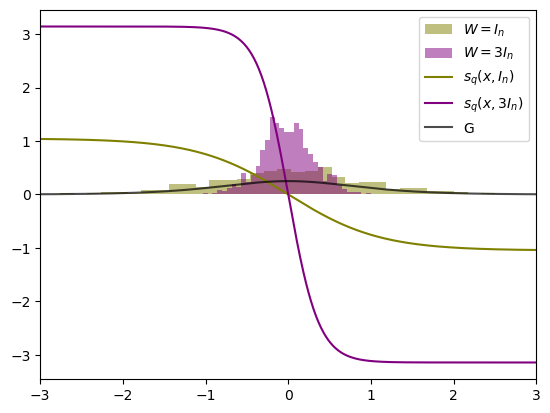

In [38]:
n = 1000
G = lambda x: np.exp(-2*np.log(np.cosh(np.pi/(2*np.sqrt(3)) * x )) - np.log(4))
x = np.linspace(-5,5,n)
W_k = np.eye(n)
W_inv_k =  np.linalg.inv(W_k)
W_f = np.eye(n) * 3
W_inv_f =  np.linalg.inv(W_f)
W_ff = np.eye(n) * 0.5
W_inv_ff =  np.linalg.inv(W_ff)

sample1 = sample_x(n,W_inv_k)
sample2 = sample_x(n,W_inv_f)
sample3 = sample_x(n,W_inv_ff)
    
plt.hist(sample1, density=True, alpha = 0.5,bins = 50,label= '$W = I_n$', color = 'olive')
plt.hist(sample2, density=True, alpha = 0.5,bins = 50, label='$W = 3 I_n$', color = 'purple')

plt.plot(x, s_q(x.reshape(-1,1),W_k) , label = '$s_q(x,I_n)$', color = 'olive')
plt.plot(x, s_q(x.reshape(-1,1),W_f), label = '$s_q(x,3 I_n$)', color = 'purple')

plt.plot(x, G(x), label = 'G',color = 'black',alpha = 0.7)

plt.xlim(right=3)  
plt.xlim(left=-3)  
plt.legend()
plt.savefig(fname = 'sample1.pdf')


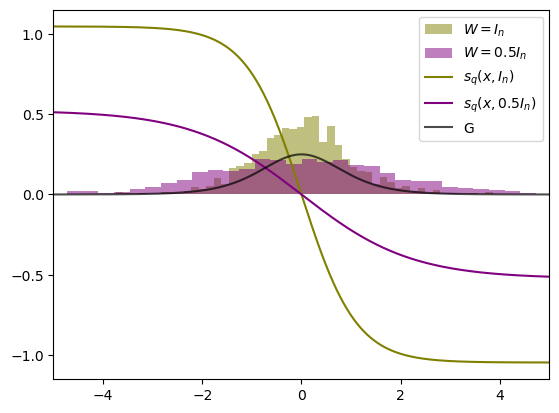

In [39]:
n = 1000
G = lambda x: np.exp(-2*np.log(np.cosh(np.pi/(2*np.sqrt(3)) * x )) - np.log(4))
x = np.linspace(-5,5,n)
W_k = np.eye(n)
W_inv_k =  np.linalg.inv(W_k)
W_f = np.eye(n) * 3
W_inv_f =  np.linalg.inv(W_f)
W_ff = np.eye(n) * 0.5
W_inv_ff =  np.linalg.inv(W_ff)

sample1 = sample_x(n,W_inv_k)

sample3 = sample_x(n,W_inv_ff)
    
plt.hist(sample1, density=True, alpha = 0.5,bins = 50,label= '$W = I_n$', color = 'olive')

plt.hist(sample3, density=True, alpha = 0.5,bins = 50, label='$W = 0.5 I_n$', color = 'purple')
plt.plot(x, s_q(x.reshape(-1,1),W_k) , label = '$s_q(x,I_n)$', color = 'olive')

plt.plot(x, s_q(x.reshape(-1,1),W_ff), label = '$s_q(x,0.5I_n$)', color = 'purple')
plt.plot(x, G(x), label = 'G',color = 'black',alpha = 0.7)

plt.xlim(right=5)  
plt.xlim(left=-5)  
plt.legend()
plt.savefig(fname = 'sample2.pdf')


## Test

In [9]:
def test_KSD(sample_size, s_q, sample_x,i,scale):
    print(i)
    error_rate = 0
    n = sample_size
    alpha = 0.05
    
    W = np.eye(n)
    W_inv =  np.linalg.inv(W)
    
    W_f = np.eye(n) * scale
    
    for i in range(1000): 
        
        # 0 Richtige Verteilung; 1 Falsche Verteilung
        d = random.choice([0,1])
        if d == 0:
            x = sample_x(n,W_inv)
            u, ksd = KSD(x,W,s_q)

            p = boot(1000,sample_size,u,ksd)
            if p < alpha:
                error_rate = error_rate + 1
        else: 
            x =  sample_x(n,W_inv)
            u,ksd = KSD(x, W_f,s_q)
            p = boot(1000,sample_size,u,ksd)
            if p > alpha:
                error_rate = error_rate + 1
    return error_rate/1000


0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


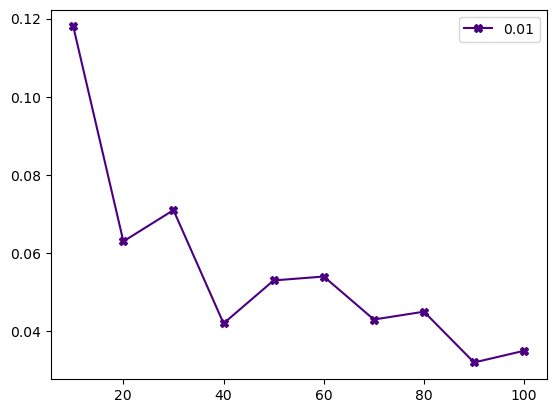

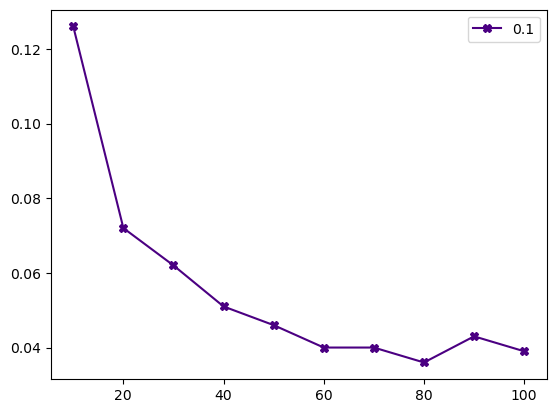

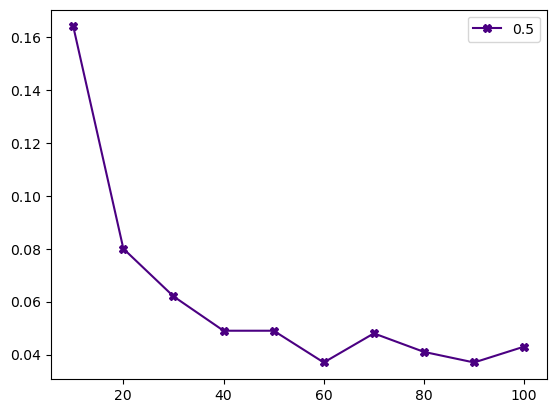

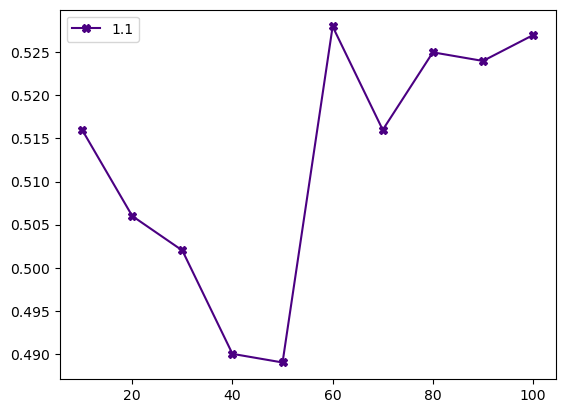

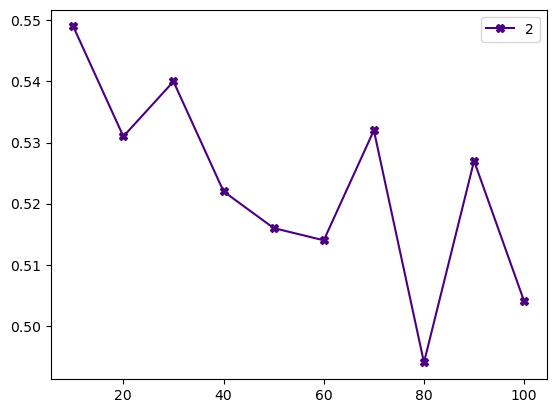

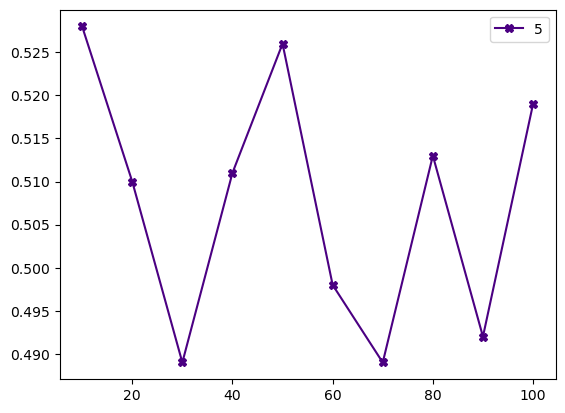

<Figure size 640x480 with 0 Axes>

In [10]:
counter = 0
for scale in [0.01,0.1,0.5,1.1,2,5]:
    counter = counter +1
    sample_sizes = np.linspace(10, 100, 10, dtype=int)
    errors = []
    for i in range(len(sample_sizes)):
        error = test_KSD(sample_sizes[i],s_q, sample_x,i,scale)
        errors.append(error)

    plt.plot(sample_sizes,errors,label = scale, color = 'indigo',marker = 'X',linestyle= '-')
    plt.legend()
    plt.savefig(fname='20september %s'%counter)
    plt.figure()